# **Players Analysis**

**Objective: Identify high-performing and consistent players (2020-2025)**
- Focus on players with high performance and consistency in the past five years.
- Use Efficiency (EFF) as the primary metric:

$$EFF = \frac{(PTS+REB+AST+STL+BLK)−((FGA−FGM)+(FTA−FTM)+TO)}{GP}$$

Where:
- PTS: Points scored
- REB: Total rebounds (offensive + defensive)
- AST: Assists
- STL: Steals
- BLK: Blocks
- FGA, FGM: Field goals attempted and made
- FTA, FTM: Free throws attempted and made
- TO: Turnovers
- GP: Games played

**Analysis Focus:**
- Evaluate trends in Efficiency (EFF) over the past five years.
- Identify players with high consistency in performance across seasons.


### **Import modules**

In [1]:
# Packages for data manipulation
import numpy as np
import pandas as pd
from collections import Counter

# Packages for data visualization
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
import seaborn as sns

### **Load datasets**

In [2]:
nba_roster = pd.read_csv("final_data/nba_roster.csv")
nba_stats = pd.read_csv("final_data/player_stats.csv")

### **Understand the data**

In `nba_roster.csv` has 9 columns where:

| Column Name | Description |
| --- | --- |
| player | The name of player |
| # | The player's jersey number | 
| pos | The player's position on the team | 
| height | The player's height |
| weight | The player's weight | 
|exp | The number of years the player has been in the NBA (experience) |
| how_acquired | How the player joined the team, such as through a trade, draft, free agency, etc.|
| team | The name of the team the player plays for |
| season | The NBA season in which the player is part of the roster |

In `player_stats` has 29 columns where:

| Column Name | Description |
| --- | --- |
| season | The NBA season for the statistics |
| team | The team of player is playing for during that season |
| pos | The player's position |
| g | Games played by the player during the season |
| gs | Games started by the player during the season |
| mp | Minutes played per game |
| fg | Field goals made by the player |
| fga | Field goals attempted by the player |
| fg% | Field goal percentage (calculated as FG made / FG attempted) |
| 3p | Three-point field goals made by the player |
| 3pa | Three-point field goals attempted by the player |
| 3p% | Three-point field goal percentage (3P made / 3P attempted) |
| 2p | Two-point field goals made by the player |
| 2pa | Two-point field goals attempted by the player |
| 2p% | Two-point field goal percentage (2P made / 2P attempted) |
| efg% | Effective field goal percentage, which gives more weight to three-point shots (calculated as (FG made + 0.5 * 3P made) / FG attempted) |
| ft | Free throws made by the player |
| fta | Free throws attempted by the player |
| ft% | Free throw percentage (FT made / FT attempted) | 
| orb | Offensive rebounds grabbed by the player |
| drb | Defensive rebounds grabbed by the player |
| trb | Total rebounds grabbed by the player (offensive + defensive rebounds) |
| ast | Assists made by the player |
| stl | Steals made by the player |
| blk | Blocks made by the player |
| tov | Turnovers committed by the player |
| pf | Personal fouls committed by the player |
| pts | Points scored by the player |
| name | The player's name |

In [3]:
nba_roster = nba_roster[['player', 'height', 'weight', 'age', 'exp', 'team', 'season']]

nba_roster = nba_roster.rename(columns={'player': 'name'})

### **Clean data**

**Check if any null / missing values or duplicates in roster**

In [4]:
nba_roster.isnull().sum()

name      0
height    0
weight    0
age       0
exp       0
team      0
season    0
dtype: int64

In [5]:
nba_roster.duplicated().sum()

0

**Check if any null / missing values or duplicates in player stats**

In [6]:
nba_stats.duplicated().sum()

0

In [7]:
nba_stats.isnull().sum()

season      0
team        0
pos         0
g           0
gs          0
mp          0
fg          0
fga         0
fg%        27
3p          0
3pa         0
3p%       238
2p          0
2pa         4
2p%        60
efg%       23
ft          0
fta         5
ft%       214
orb         0
drb         0
trb         0
ast         0
stl         0
blk         0
tov         0
pf          0
pts        17
name        0
dtype: int64

In [8]:
null_records = nba_stats[nba_stats.isnull().any(axis=1)]

null_records

,season,team,pos,g,gs,mp,fg,fga,fg%,3p,...,orb,drb,trb,ast,stl,blk,tov,pf,pts,name
7,2013-2014,Oklahoma City Thunder,C,81.0,20.0,1197.0,93.0,185.0,0.503,0.0,...,142.0,190.0,332.0,43.0,40.0,57.0,71.0,203.0,265.0,Steven Adams
9,2015-2016,Oklahoma City Thunder,C,80.0,80.0,2014.0,261.0,426.0,0.613,0.0,...,219.0,314.0,533.0,62.0,42.0,89.0,84.0,223.0,636.0,Steven Adams
17,2024-2025,Houston Rockets,C,18.0,0.0,186.0,17.0,28.0,0.607,0.0,...,28.0,38.0,66.0,19.0,5.0,4.0,21.0,19.0,44.0,Steven Adams
59,2020-2021,Brooklyn Nets,C,12.0,5.0,320.0,44.0,65.0,0.677,0.0,...,38.0,87.0,125.0,20.0,7.0,19.0,22.0,21.0,134.0,Jarrett Allen
106,2015-2016,New York Knicks,SF,2.0,0.0,6.0,3.0,4.0,0.750,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,6.0,Thanasis Antetokounmpo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5039,2018-2019,Los Angeles Lakers,C,33.0,12.0,516.0,112.0,193.0,0.580,0.0,...,54.0,108.0,162.0,25.0,4.0,27.0,33.0,73.0,281.0,Ivica Zubac
5040,2018-2019,Los Angeles Clippers,C,26.0,25.0,524.0,100.0,186.0,0.538,0.0,...,61.0,139.0,200.0,38.0,10.0,24.0,37.0,64.0,244.0,Ivica Zubac
5043,2021-2022,Los Angeles Clippers,C,76.0,76.0,1852.0,310.0,495.0,0.626,0.0,...,217.0,427.0,644.0,120.0,36.0,77.0,114.0,203.0,785.0,Ivica Zubac
5045,2023-2024,Los Angeles Clippers,C,68.0,68.0,1794.0,337.0,519.0,0.649,0.0,...,196.0,430.0,626.0,93.0,22.0,83.0,79.0,180.0,794.0,Ivica Zubac


**Handle the null / missing values in player stats**

In [9]:
for col in nba_stats.columns:
    if nba_stats[col].isnull().any():  
        nba_stats[col] = nba_stats.groupby('pos')[col].transform(lambda x: x.fillna(x.mean()))

nba_stats.isnull().sum()

season    0
team      0
pos       0
g         0
gs        0
mp        0
fg        0
fga       0
fg%       0
3p        0
3pa       0
3p%       0
2p        0
2pa       0
2p%       0
efg%      0
ft        0
fta       0
ft%       0
orb       0
drb       0
trb       0
ast       0
stl       0
blk       0
tov       0
pf        0
pts       0
name      0
dtype: int64

### **Pre-processing data**

In [10]:
nba_roster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2577 entries, 0 to 2576
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    2577 non-null   object
 1   height  2577 non-null   int64 
 2   weight  2577 non-null   object
 3   age     2577 non-null   int64 
 4   exp     2577 non-null   object
 5   team    2577 non-null   object
 6   season  2577 non-null   object
dtypes: int64(2), object(5)
memory usage: 141.1+ KB


The exp (experience) column is expected to be numerical because it represents the number of years a player has played in the NBA. However, based on the information above, it appears to be a categorical value so we need to investigate what caused this problem.

In [11]:
nba_roster["exp"].unique()

array(['7', '15', '8', '4', '1', '2', 'R', '3', '17', '6', '14', '16',
       '5', '13', '9', '12', '10', '11', '18', '19', '21', '20'],
      dtype=object)

We need to identify all records that contain the **R** value in the **exp** column.

In [12]:
nba_roster[nba_roster["exp"] == "R"]

,name,height,weight,age,exp,team,season
10,Anton Watson,80,225,24,R,Boston Celtics,2024-2025
15,Baylor Scheierman,78,205,24,R,Boston Celtics,2024-2025
24,Drew Peterson,81,205,24,R,Boston Celtics,2023-2024
27,Jordan Walsh,78,205,20,R,Boston Celtics,2023-2024
41,JD Davison,73,195,20,R,Boston Celtics,2022-2023
...,...,...,...,...,...,...,...
2548,Joe Wieskamp,78,205,22,R,San Antonio Spurs,2021-2022
2550,DJ Stewart,77,205,22,R,San Antonio Spurs,2021-2022
2558,Jock Landale,83,255,26,R,San Antonio Spurs,2021-2022
2571,Devin Vassell,77,200,20,R,San Antonio Spurs,2020-2021


Now, we pick a random player from the list (for example, **JD Davison**) to view all of his records.

In [13]:
nba_roster[nba_roster["name"] == "JD Davison"]

,name,height,weight,age,exp,team,season
7,JD Davison,73,195,22,2,Boston Celtics,2024-2025
25,JD Davison,73,195,21,1,Boston Celtics,2023-2024
41,JD Davison,73,195,20,R,Boston Celtics,2022-2023


We can observe that **JD Davison**'s experience (**exp**) increases with each season from 2022 to 2025. In the 2024-2025 season, he has 2 years of experience, and in the 2023-2024 season, he has 1 year of experience.

From this, we can conclude that the R value in the exp column indicates that the player has no experience (or is a Rookie) and we will not collect the Rookie in 2024-2025 (currently).

In [14]:
nba_roster = nba_roster[(nba_roster["exp"] != "R") & (nba_roster["season"] != "2024-25")]

nba_roster["exp"] = pd.to_numeric(nba_roster["exp"])

In [15]:
nba_roster.describe()

,height,age,exp
count,2141.000000,2141.000000,2141.000000
mean,78.455862,26.872489,5.187296
std,3.248370,4.182640,3.945771
min,68.000000,20.000000,1.000000
25%,76.000000,24.000000,2.000000
50%,78.000000,26.000000,4.000000
75%,81.000000,30.000000,7.000000
max,89.000000,43.000000,21.000000


---------------

In [16]:
nba_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5047 entries, 0 to 5046
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   season  5047 non-null   object 
 1   team    5047 non-null   object 
 2   pos     5047 non-null   object 
 3   g       5047 non-null   float64
 4   gs      5047 non-null   float64
 5   mp      5047 non-null   float64
 6   fg      5047 non-null   float64
 7   fga     5047 non-null   float64
 8   fg%     5047 non-null   float64
 9   3p      5047 non-null   float64
 10  3pa     5047 non-null   float64
 11  3p%     5047 non-null   float64
 12  2p      5047 non-null   float64
 13  2pa     5047 non-null   float64
 14  2p%     5047 non-null   float64
 15  efg%    5047 non-null   float64
 16  ft      5047 non-null   float64
 17  fta     5047 non-null   float64
 18  ft%     5047 non-null   float64
 19  orb     5047 non-null   float64
 20  drb     5047 non-null   float64
 21  trb     5047 non-null   float64
 22  

In [17]:
nba_stats.describe()

,g,gs,mp,fg,fga,fg%,3p,3pa,3p%,2p,...,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts
count,5047.000000,5047.000000,5047.000000,5047.000000,5047.000000,5047.000000,5047.000000,5047.000000,5047.000000,5047.000000,...,5047.000000,5047.000000,5047.000000,5047.000000,5047.000000,5047.000000,5047.000000,5047.000000,5047.000000,5047.000000
mean,43.476323,22.551813,1041.919358,179.027541,384.619576,0.451943,48.812760,135.732713,0.849015,130.467406,...,1.173188,45.244502,145.549435,189.227660,107.870220,34.029324,21.477908,59.829602,85.344363,487.331410
std,25.330049,26.596194,832.979893,173.514357,366.102631,0.109217,56.588189,148.829977,7.937255,138.876728,...,7.896959,53.510902,140.092373,185.816218,130.434168,31.908614,27.501729,60.776133,67.218598,480.491479
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,1.000000,295.500000,38.000000,87.000000,0.407000,4.000000,14.000000,0.286000,23.000000,...,0.690000,10.000000,36.000000,47.000000,19.000000,8.000000,4.000000,13.000000,27.000000,102.000000
50%,45.000000,9.000000,864.000000,125.000000,270.000000,0.447000,28.000000,85.000000,0.344000,84.000000,...,0.775000,28.000000,108.000000,139.000000,63.000000,26.000000,12.000000,42.000000,73.000000,339.000000
75%,67.000000,41.000000,1727.000000,270.000000,581.000000,0.500000,76.500000,214.500000,0.389000,193.500000,...,0.837500,60.000000,215.000000,276.500000,142.500000,51.000000,28.000000,87.000000,134.000000,732.000000
max,84.000000,83.000000,3388.000000,875.000000,1941.000000,1.000000,402.000000,1028.000000,261.000000,803.000000,...,295.000000,440.000000,848.000000,1247.000000,925.000000,217.000000,254.000000,464.000000,610.000000,2818.000000


In [18]:
merged_data = pd.merge(
    nba_stats,
    nba_roster,
    how="inner",
    left_on=["name", "team", "season"],
    right_on=["name", "team", "season"],
)

merged_data.head(10)

,season,team,pos,g,gs,mp,fg,fga,fg%,3p,...,stl,blk,tov,pf,pts,name,height,weight,age,exp
0,2021-2022,Toronto Raptors,C,73.0,28.0,1725.0,265.0,603.0,0.439,56.0,...,37.0,41.0,84.0,151.0,664.0,Precious Achiuwa,80,225,22,1
1,2022-2023,Toronto Raptors,C,55.0,12.0,1140.0,196.0,404.0,0.485,29.0,...,31.0,30.0,59.0,102.0,508.0,Precious Achiuwa,80,225,23,2
2,2023-2024,New York Knicks,PF,49.0,18.0,1187.0,157.0,299.0,0.525,13.0,...,30.0,56.0,54.0,103.0,372.0,Precious Achiuwa,80,243,24,3
3,2024-2025,New York Knicks,PF,10.0,1.0,195.0,21.0,46.0,0.457,3.0,...,8.0,9.0,10.0,14.0,52.0,Precious Achiuwa,80,243,25,4
4,2020-2021,New Orleans Pelicans,C,58.0,58.0,1605.0,189.0,308.0,0.614,0.0,...,54.0,38.0,78.0,113.0,438.0,Steven Adams,83,265,27,7
5,2021-2022,Memphis Grizzlies,C,76.0,75.0,1999.0,210.0,384.0,0.547,0.0,...,65.0,60.0,115.0,153.0,528.0,Steven Adams,83,265,28,8
6,2022-2023,Memphis Grizzlies,C,42.0,42.0,1133.0,157.0,263.0,0.597,0.0,...,36.0,46.0,79.0,98.0,361.0,Steven Adams,83,265,29,9
7,2024-2025,Houston Rockets,C,18.0,0.0,186.0,17.0,28.0,0.607,0.0,...,5.0,4.0,21.0,19.0,44.0,Steven Adams,83,265,31,10
8,2020-2021,Miami Heat,C,64.0,64.0,2143.0,456.0,800.0,0.570,2.0,...,75.0,66.0,169.0,145.0,1197.0,Bam Adebayo,81,255,23,3
9,2021-2022,Miami Heat,C,56.0,56.0,1825.0,406.0,729.0,0.557,0.0,...,80.0,44.0,148.0,171.0,1068.0,Bam Adebayo,81,255,24,4


### **Evaluate trends in Efficiency (EFF) over the past five years**

**Question 1: What is the information of eff of the NBA players though each season?**

In [19]:
seasons = ["2020-2021", "2021-2022", "2022-2023", "2023-2024", "2024-2025"]

merged_data['eff'] = (
    (merged_data['pts'] + merged_data['trb'] + merged_data['ast'] + merged_data['stl'] + merged_data['blk']) - 
    ((merged_data['fga'] - merged_data['fg']) + (merged_data['fta'] - merged_data['ft']) + merged_data['tov'])
) / merged_data['g']

merged_data = merged_data[merged_data['season'].isin(seasons)]

season_group = merged_data.groupby(by='season')

for year, group in season_group:
    desc = group['eff'].describe()
    print(f"{year:<10} Count: {desc['count']:<6.0f} 25%: {desc['25%']:<8.2f} Mean: {desc['mean']:<8.2f} 75%: {desc['75%']:<8.2f} Std: {desc['std']:<8.2f} Min: {desc['min']:<8.2f} Max: {desc['max']:<8.2f}")

2020-2021  Count: 315    25%: 8.01     Mean: 12.75    75%: 16.46    Std: 6.99     Min: -0.06    Max: 35.90   
2021-2022  Count: 336    25%: 7.58     Mean: 12.28    75%: 16.22    Std: 6.85     Min: -1.00    Max: 38.68   
2022-2023  Count: 373    25%: 6.83     Mean: 12.16    75%: 16.68    Std: 7.09     Min: 0.29     Max: 38.00   
2023-2024  Count: 404    25%: 5.54     Mean: 11.55    75%: 16.54    Std: 7.47     Min: -0.14    Max: 38.47   
2024-2025  Count: 404    25%: 5.12     Mean: 11.10    75%: 15.81    Std: 7.75     Min: -28.46   Max: 41.42   


**Comments**

The decrease in average efficiency (eff) of players over the past five seasons (from **12.75** in 2020-2021 to **11.11** in 2024-2025). 

=> With a slight overall decline in player efficiency across the league, it suggests that **the overall performance of players on average has less efficient in recent years** which could be due to various factors such as changes in playing styles, team strategies, or player roles.

--

The efficiency of the lowest 25% of players has consistently decreased over time (from **8.01** in 2020-2021 to **5.12** in 2024-2025). 

=> This indicates that **the performance gap between the less efficient players has become smaller**, with the bottom-performing players having lower efficiency scores in recent years. 

=> Besides that, the efficiency of the **top 25% of players has also gradually decreased** (from 16.46 in 2020-2021 to 15.81 in 2024-2025), **reflecting a potential shift in player performance or distribution**.

-- 

About the range of efficiency:

=> **The minimum efficiency has varied widely across seasons**, from a low of **-0.06** in 2020-2021 to **-26.63** in 2024-2025. This represents **a few extreme outliers where players had very poor performances, with the most negative values occurring in 2024-2025** 

=> **The maximum efficiency has increased** from 35.90 in 2020-2021 to 41.42 in 2024-2025 which suggests that **some exceptional players continue to push the limits of individual performance**, achieving higher efficiency scores in more recent seasons.

**Question 2: Visualize the eff of the NBA players though each season**

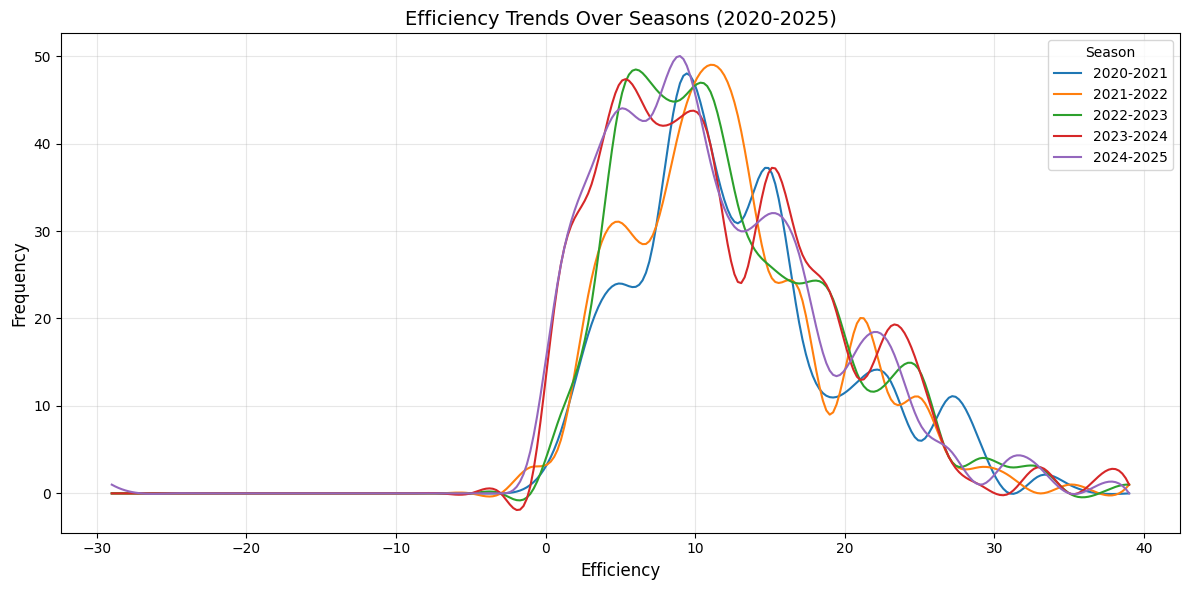

In [20]:
filtered_data = merged_data[merged_data["season"].isin(seasons)]

bins = np.arange(-30, 41, 2)  

plt.figure(figsize=(12, 6))

for season in seasons:
    season_data = filtered_data[filtered_data["season"] == season]["eff"]
    hist, _ = np.histogram(season_data, bins=bins)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    spline = make_interp_spline(bin_centers, hist, k=3)
    smooth_bins = np.linspace(bin_centers.min(), bin_centers.max(), 300)
    smooth_counts = spline(smooth_bins)
    
    plt.plot(smooth_bins, smooth_counts, label=season)

plt.title("Efficiency Trends Over Seasons (2020-2025)", fontsize=14)
plt.xlabel("Efficiency", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(title="Season", fontsize=10, loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()

**Comments**

- About the shape, the efficiency (eff) distribution for all seasons retain **a bell-shaped curve**, indicating a normal-like distribution. **Most players' efficiencies cluster around the central range (approximately 5-15).**
- There is a significant overlap in the distributions across seasons so it shows that the efficiency metric has **remained overall consistent or stable for most players, with only minor shifts in variability and extreme values**.

### **Identify players with high consistency in performance across seasons by Efficiency (eff)**

**Question 3: What is the change in efficiency of each player though each season?**

In [21]:
player_season_data = merged_data.groupby(['name', 'season']).agg({'eff': 'mean'}).reset_index()

player_season_data['eff_change'] = player_season_data.groupby('name')['eff'].diff()

player_season_data

,name,season,eff,eff_change
0,A.J. Lawson,2023-2024,3.095238,NaN
1,A.J. Lawson,2024-2025,4.500000,1.404762
2,AJ Griffin,2023-2024,1.100000,NaN
3,Aaron Gordon,2020-2021,12.520000,NaN
4,Aaron Gordon,2021-2022,16.653333,4.133333
...,...,...,...,...
1827,Ziaire Williams,2024-2025,9.571429,1.473389
1828,Zion Williamson,2020-2021,27.540984,NaN
1829,Zion Williamson,2022-2023,27.000000,-0.540984
1830,Zion Williamson,2023-2024,23.900000,-3.100000


The players have an **eff_change value** of **NaN** because they have only played one season, so there is no previous data for comparison. We will remove them from the dataset.

In [22]:
player_season_data_grouped = player_season_data.groupby(by='name')

filtered_data = player_season_data_grouped.filter(lambda x: len(x) > 1)
filtered_data = filtered_data.reset_index().drop(columns='index')

filtered_data.head()

,name,season,eff,eff_change
0,A.J. Lawson,2023-2024,3.095238,NaN
1,A.J. Lawson,2024-2025,4.500000,1.404762
2,Aaron Gordon,2020-2021,12.520000,NaN
3,Aaron Gordon,2021-2022,16.653333,4.133333
4,Aaron Gordon,2022-2023,19.264706,2.611373


After removing players who have only played one season, the dataset still contains **eff_change** values of **NaN** because it is their first season in the NBA, and there is no previous data for comparison. We will replace these NaN values with **0**.

In [23]:
filtered_data['eff_change'] = filtered_data['eff_change'].replace(np.nan, 0)

filtered_data.head()

,name,season,eff,eff_change
0,A.J. Lawson,2023-2024,3.095238,0.000000
1,A.J. Lawson,2024-2025,4.500000,1.404762
2,Aaron Gordon,2020-2021,12.520000,0.000000
3,Aaron Gordon,2021-2022,16.653333,4.133333
4,Aaron Gordon,2022-2023,19.264706,2.611373


**Question 4: Calculate the standard deviation of the efficiency change for each player**


In [24]:
player_std_data = (filtered_data.groupby('name')['eff_change']
                   .std()
                   .reset_index()
                   .replace(np.nan, 0))

player_std_data.rename(columns={'eff_change': 'eff_std'}, inplace=True)

player_std_data

,name,eff_std
0,A.J. Lawson,0.993317
1,Aaron Gordon,2.480917
2,Aaron Holiday,2.980956
3,Aaron Nesmith,3.924038
4,Aaron Wiggins,0.298157
...,...,...
458,Zach Collins,3.606957
459,Zach LaVine,2.161761
460,Zeke Nnaji,1.567625
461,Ziaire Williams,1.481459


**Question 5: Identify players with high consistency (low standard deviation) in performance across seasons**


In [25]:
# Filter for players with low standard deviation (high consistency)
mean = player_std_data['eff_std'].mean()
std_dev = player_std_data['eff_std'].std()
threshold = mean - std_dev

high_consistency_players = player_std_data[player_std_data['eff_std'] < threshold]

high_consistency_players = high_consistency_players.sort_values(by='eff_std', ascending=True).reset_index().drop(columns='index')

high_consistency_players

,name,eff_std
0,Devontae Cacok,0.012740
1,Dalen Terry,0.059496
2,Johnny Juzang,0.063640
3,Moses Brown,0.082842
4,Ousmane Dieng,0.157555
5,Nikola Jović,0.157764
6,Rodney McGruder,0.162925
7,Mark Williams,0.229117
8,Aaron Wiggins,0.298157
9,Kira Lewis Jr.,0.302379


**Question 6: Visualize top 10 players with high consistency (low standard deviation) in performance across seasons**

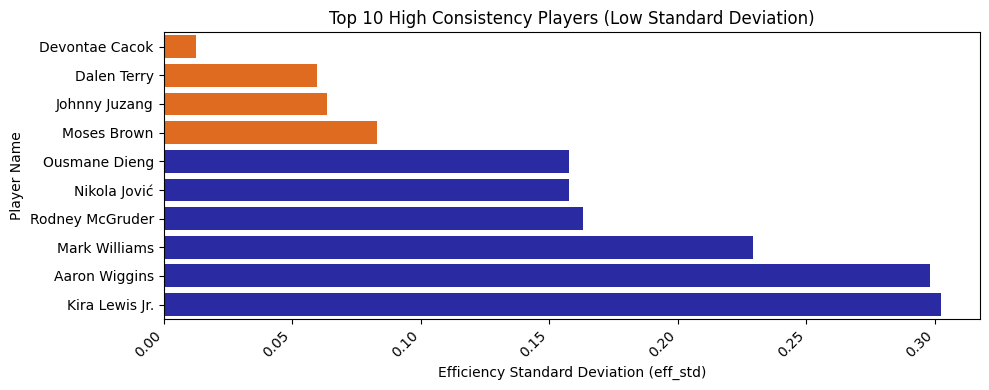

In [26]:
top_10_players = high_consistency_players.head(10)

plt.figure(figsize=(10, 4))
sns.barplot(data=top_10_players, x='eff_std', y='name', orient='h',
            hue='name', palette=['#FF6400' if std < 0.1 else '#1616B7' for std in top_10_players['eff_std']])

plt.ylabel('Player Name')
plt.xlabel('Efficiency Standard Deviation (eff_std)')
plt.title('Top 10 High Consistency Players (Low Standard Deviation)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

**Comments**
- **Devontae Cacok** is the most consistent player, with a standard deviation of under 0.05, creating a significant gap compared to all the remaining players.
- **Dalen Terry** and **Johnny Juzang** follow closely as highly consistent players, with only a small difference in their standard deviations.
- **Moses Brown**, the fourth player, has a standard deviation that is twice as low as the player ranked immediately below him.